<a href="https://colab.research.google.com/github/mariolopezguasp/AgrupamientoSonidos/blob/main/3ModeloNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/dataset_ia_log_returns_10y.csv', index_col=0, parse_dates=True)


X = df.iloc[:-1].values
y = df.iloc[1:].values

n = len(X)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"Train size: {X_train.shape}, Val size: {X_val.shape}, Test size: {X_test.shape}")


Train size: (1757, 12), Val size: (376, 12), Test size: (377, 12)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Parameters: 156


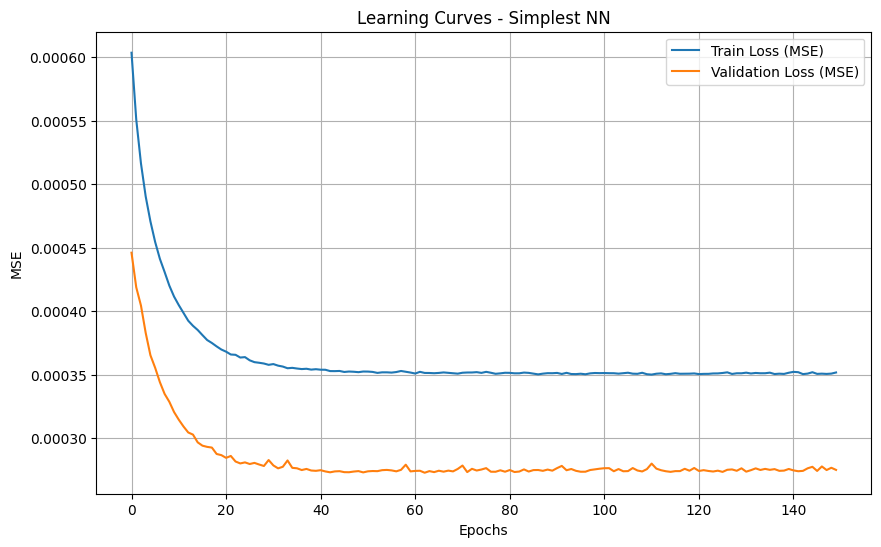

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Train MSE: 0.000349
Validation MSE: 0.000275
Test MSE: 0.000325


In [3]:

import sys
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_simple_nn(input_dim, output_dim):
    """
    Returns the simplest possible neural network (minimum parameters)
    for multivariant regression.
    It is just a single Dense layer without activation function (Linear regression analogy).
    """
    model = Sequential([
        Dense(output_dim, input_shape=(input_dim,), activation=None)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train the model
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
model = get_simple_nn(input_dim, output_dim)

num_params = model.count_params()
print(f"Model Parameters: {num_params}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    verbose=0
)

# Show converging learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.title('Learning Curves - Simplest NN')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
mse_val = mean_squared_error(y_val, y_val_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.6f}")
print(f"Validation MSE: {mse_val:.6f}")
print(f"Test MSE: {mse_test:.6f}")

results_nn = {'train_mse': mse_train, 'val_mse': mse_val, 'test_mse': mse_test, 'params': num_params}
with open('results_nn.json', 'w') as f: json.dump(results_nn, f)


In [11]:
rmse_train_nn = np.sqrt(mse_train)
rmse_val_nn = np.sqrt(mse_val)
rmse_test = np.sqrt(mse_test)

print("--- Root Mean Squared Error (RMSE) - Red Neuronal Simple ---")
print(f"Train RMSE: {rmse_train_nn:.6f} (Desviación media del modelo: {rmse_train_nn*100:.2f}%)")
print(f"Validation RMSE: {rmse_val_nn:.6f} (Desviación media del modelo: {rmse_val_nn*100:.2f}%)")
print(f"Test RMSE: {rmse_test:.6f} (Desviación media del modelo: {rmse_test*100:.2f}%)")
print("-" * 60)

--- Root Mean Squared Error (RMSE) - Red Neuronal Simple ---
Train RMSE: 0.018690 (Desviación media del modelo: 1.87%)
Validation RMSE: 0.016580 (Desviación media del modelo: 1.66%)
Test RMSE: 0.018037 (Desviación media del modelo: 1.80%)
------------------------------------------------------------


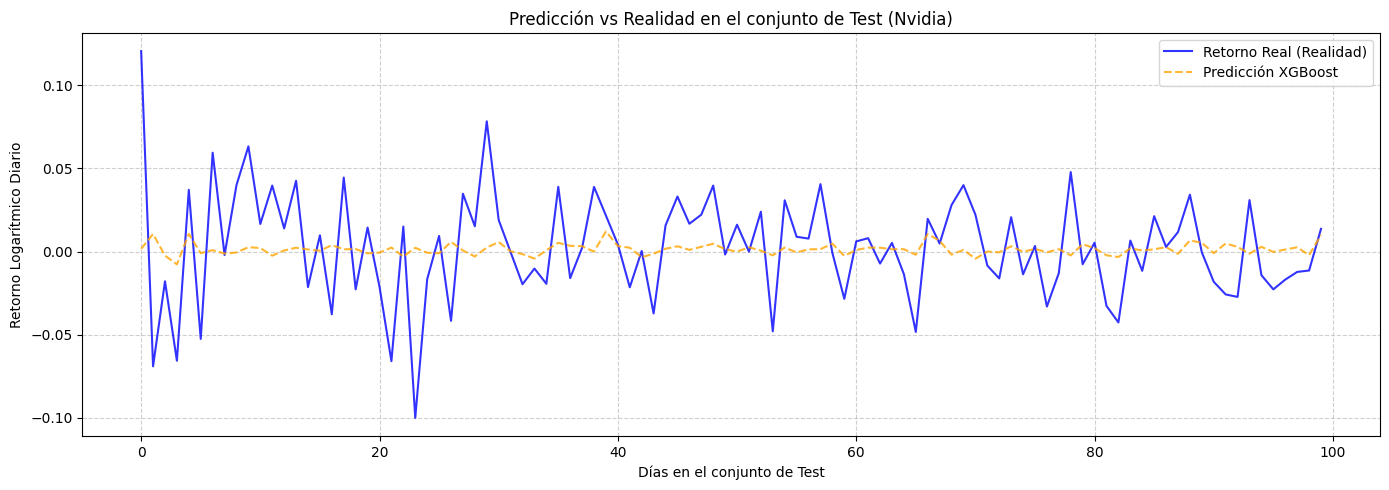

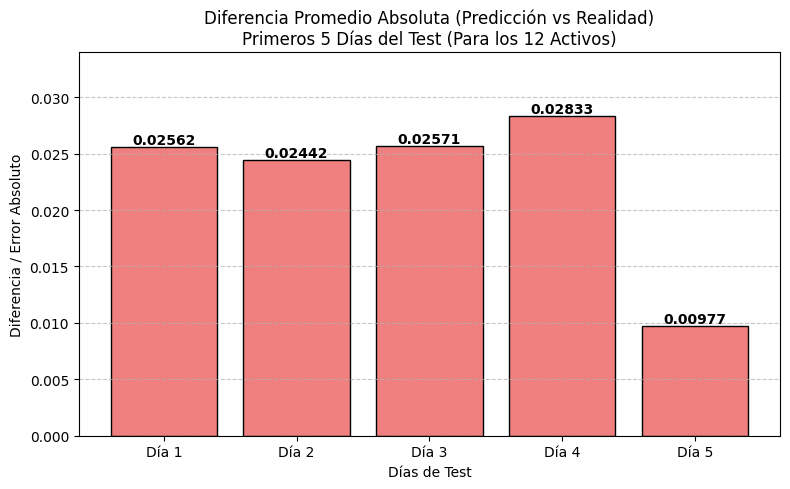

In [8]:
import numpy as np
import matplotlib.pyplot as plt




y_test_array = y_test.values if hasattr(y_test, 'values') else y_test

asset_index = 2 # 0 = JPM, 1 = ETN, 2 = NVDA... (Cambia este número para ver otras acciones)

plt.figure(figsize=(14, 5))
plt.plot(y_test_array[:100, asset_index], label='Retorno Real (Realidad)', alpha=0.8, color='blue')
plt.plot(y_test_pred[:100, asset_index], label='Predicción XGBoost', alpha=0.8, color='orange', linestyle='--')
plt.title(f'Predicción vs Realidad en el conjunto de Test (Nvidia)')
plt.xlabel('Días en el conjunto de Test')
plt.ylabel('Retorno Logarítmico Diario')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------------------
# 3. Gráfica 2: Diferencia Promedio (Error) de los primeros 5 días
# -------------------------------------------------------------------------
# Calculamos la diferencia absoluta (|Realidad - Predicción|)
diferencias_absolutas = np.abs(y_test_array - y_test_pred)

# Calculamos el error medio de los 12 activos (empresas) para cada día
diferencia_promedio_diaria = np.mean(diferencias_absolutas, axis=1)

# Cogemos exclusivamente los primeros 5 días de evaluación (índices 0 al 4)
primeros_5_dias = diferencia_promedio_diaria[:5]
etiquetas_dias = ['Día 1', 'Día 2', 'Día 3', 'Día 4', 'Día 5']

plt.figure(figsize=(8, 5))
barras = plt.bar(etiquetas_dias, primeros_5_dias, color='lightcoral', edgecolor='black')
plt.title('Diferencia Promedio Absoluta (Predicción vs Realidad)\nPrimeros 5 Días del Test (Para los 12 Activos)')
plt.xlabel('Días de Test')
plt.ylabel('Diferencia / Error Absoluto')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2.0, yval, f"{yval:.5f}",
             ha='center', va='bottom', fontsize=10, fontweight='bold')


plt.ylim(0, max(primeros_5_dias) * 1.2)
plt.tight_layout()
plt.show()


--- MÉTRICAS GLOBALES DEL MODELO ---
MSE Global: 0.000325
MAE Global: 0.012301
RMSE Global: 0.018037
Accuracy Direccional: 51.39% (Meta del Naive: > 50%)
------------------------------------


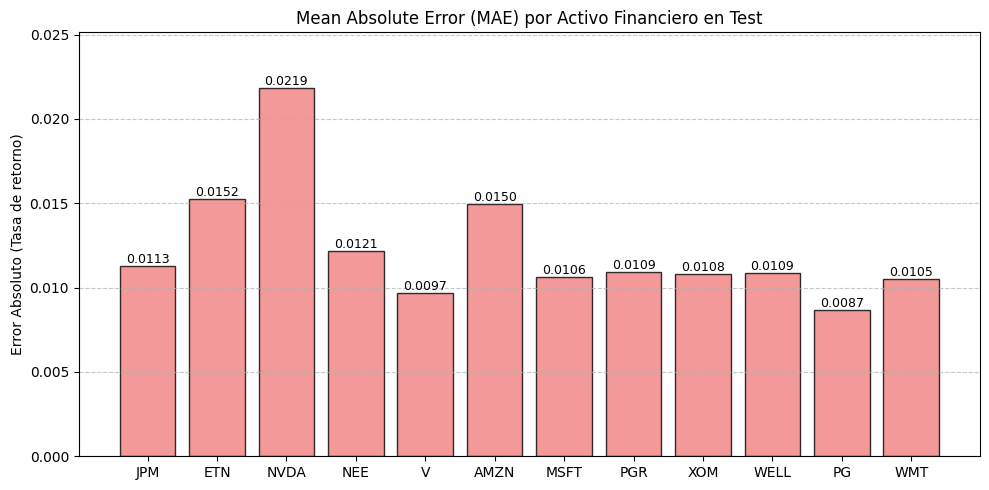

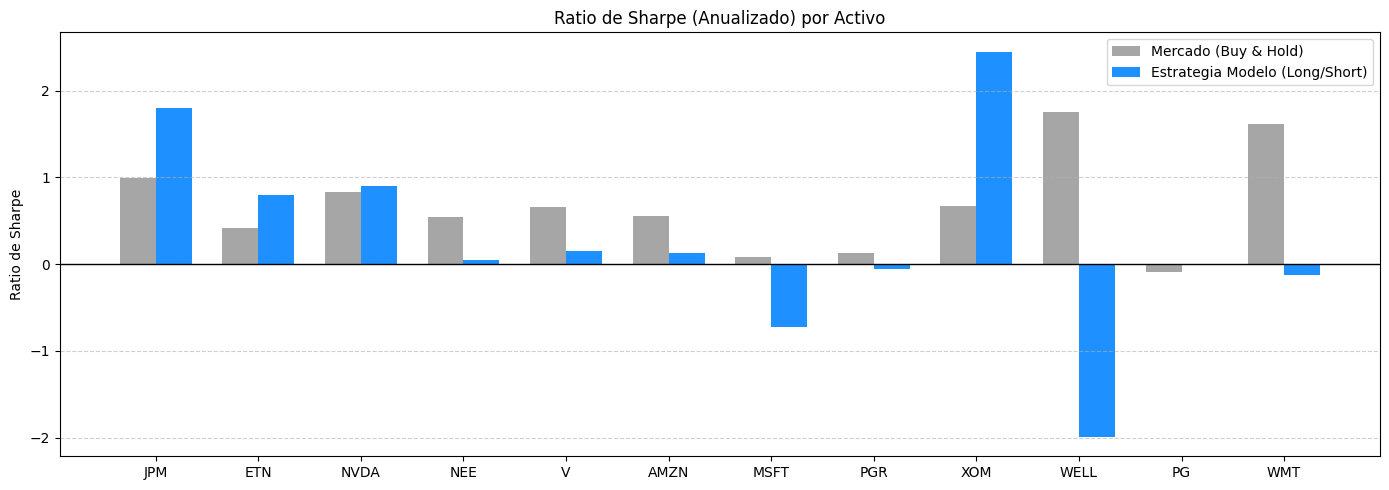

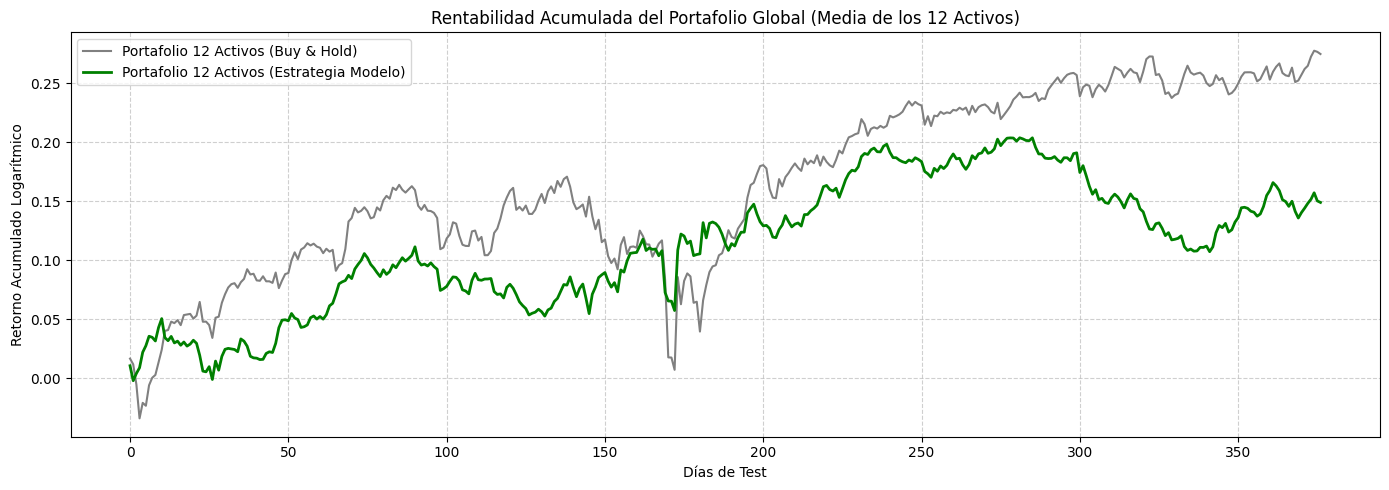

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Asegurarnos de que y_test es un array
y_test_array = y_test.values if hasattr(y_test, 'values') else y_test
nombres_activos = ["JPM","ETN","NVDA","NEE","V","AMZN","MSFT","PGR","XOM","WELL","PG","WMT"]

# =========================================================================
# 1. EVALUACIÓN DE MÉTRICAS (MSE, MAE y Accuracy Direccional)
# =========================================================================
# Cálculo de MSE y MAE global
mse_global = mean_squared_error(y_test_array, y_test_pred)
mae_global = mean_absolute_error(y_test_array, y_test_pred)

# Accuracy Direccional: % de veces que el modelo acierta el SIGNO (+ o -)
signo_real = np.sign(y_test_array)
signo_pred = np.sign(y_test_pred)
# Asumimos que predecir exactamente 0 es un fallo para simplificar, o lo ignoramos
accuracy_direccional = np.mean(signo_real == signo_pred)

print("--- MÉTRICAS GLOBALES DEL MODELO ---")
print(f"MSE Global: {mse_global:.6f}")
print(f"MAE Global: {mae_global:.6f}")
print(f"RMSE Global: {rmse_test:.6f}")
print(f"Accuracy Direccional: {accuracy_direccional*100:.2f}% (Meta del Naive: > 50%)")
print("-" * 36)



# =========================================================================
# 3. GRÁFICA 2: MAE Promedio por cada uno de los 12 activos
# =========================================================================
# Calculamos el MAE de forma individual para cada columna (activo)
mae_por_activo = np.mean(np.abs(y_test_array - y_test_pred), axis=0)

plt.figure(figsize=(10, 5))
barras = plt.bar(nombres_activos, mae_por_activo, color='lightcoral', edgecolor='black', alpha=0.8)
plt.title('Mean Absolute Error (MAE) por Activo Financiero en Test')
plt.ylabel('Error Absoluto (Tasa de retorno)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for barra in barras:
    yval = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2.0, yval, f"{yval:.4f}",
             ha='center', va='bottom', fontsize=9, rotation=0)

plt.ylim(0, max(mae_por_activo) * 1.15)
plt.tight_layout()
plt.show()

# =========================================================================
# 4. GRÁFICA 3 y 4: SIMULACIÓN DE TRADING (Porfolio y Sharpe)
# =========================================================================
# Simulamos estrategia Long/Short
senales_modelo = np.where(y_test_pred > 0, 1, -1)
retornos_estrategia = senales_modelo * y_test_array

# --- Ratio de Sharpe ---
factor_anualizacion = np.sqrt(252)
sharpe_modelo = (np.mean(retornos_estrategia, axis=0) / np.std(retornos_estrategia, axis=0)) * factor_anualizacion
sharpe_mercado = (np.mean(y_test_array, axis=0) / np.std(y_test_array, axis=0)) * factor_anualizacion

x = np.arange(len(nombres_activos))
width = 0.35

plt.figure(figsize=(14, 5))
plt.bar(x - width/2, sharpe_mercado, width, label='Mercado (Buy & Hold)', color='grey', alpha=0.7)
plt.bar(x + width/2, sharpe_modelo, width, label='Estrategia Modelo (Long/Short)', color='dodgerblue')
plt.title('Ratio de Sharpe (Anualizado) por Activo')
plt.ylabel('Ratio de Sharpe')
plt.xticks(x, nombres_activos)
plt.axhline(0, color='black', linewidth=1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# --- Curva de Capital del PORTAFOLIO COMPLETO ---
# Promediamos los retornos diarios de los 12 activos (Inversión equitativa)
retorno_diario_portafolio_mercado = np.mean(y_test_array, axis=1)
retorno_diario_portafolio_modelo = np.mean(retornos_estrategia, axis=1)

# Acumulamos
curva_portafolio_mercado = np.cumsum(retorno_diario_portafolio_mercado)
curva_portafolio_modelo = np.cumsum(retorno_diario_portafolio_modelo)

plt.figure(figsize=(14, 5))
plt.plot(curva_portafolio_mercado, label='Portafolio 12 Activos (Buy & Hold)', color='gray', linewidth=1.5)
plt.plot(curva_portafolio_modelo, label='Portafolio 12 Activos (Estrategia Modelo)', color='green', linewidth=2)
plt.title('Rentabilidad Acumulada del Portafolio Global (Media de los 12 Activos)')
plt.xlabel('Días de Test')
plt.ylabel('Retorno Acumulado Logarítmico')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
